# EIRP (Watts) and Connected UEs over Time

This notebook loads:
- Per-PCI antenna gain values (dBi) from `cell_power_changes.csv`, converts them to per-PCI EIRP in Watts assuming a nominal transmit power (editable), and computes a Total EIRP.
- Connected UEs over time from `input.csv`.

It aligns both series on a common time axis and plots them with dual y-axes. A secondary axis shows EIRP in dBW for convenience.

In [20]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Seaborn style and fonts
sns.set_theme(
    style="whitegrid",
    font_scale=1.5
)

# File paths
base = Path('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time')
file_power = base / 'cell_power_changes_20250816_144851_final.csv'
file_ues = base / 'input.csv'

file_power, file_ues

(PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/cell_power_changes_20250816_144851_final.csv'),
 PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/input.csv'))

In [21]:
# Load data
power_df = pd.read_csv(file_power)
ues_df = pd.read_csv(file_ues)

# Inspect and normalize column names
power_df.columns = [c.strip() for c in power_df.columns]
ues_df.columns = [c.strip() for c in ues_df.columns]

# Rename time columns for consistency
if 'Time(h)' in power_df.columns:
    power_df = power_df.rename(columns={'Time(h)': 'time_h'})
if 'Time(h)' in ues_df.columns:
    ues_df = ues_df.rename(columns={'Time(h)': 'time_h'})

# Identify PCI columns (assumed antenna gain values in dBi)
pci_cols = [c for c in power_df.columns if c.startswith('pci_')]

# Parameters for conversion
# Assumption: Each pci_* column represents antenna gain G(dBi). If you have actual transmit carrier power P_tx (W) per PCI, set base_tx_power_w accordingly.
# EIRP (W) = P_tx(W) * 10^(G_dBi/10)   (ignoring feeder/cable losses; subtract L_cable(dB) inside exponent if needed)
base_tx_power_w = 1.0  # TODO: replace with real per-PCI transmit power if known
cable_loss_db = 0.0    # Set >0 if you want to subtract feeder losses

# Convert each gain column to EIRP in Watts and store in new dataframe
eirp_linear_cols = []
for c in pci_cols:
    gain_dbi = power_df[c].astype(float)
    linear_gain = 10 ** ((gain_dbi - cable_loss_db) / 10.0)
    eirp_w = base_tx_power_w * linear_gain
    new_col = f"{c}_eirp_w"
    power_df[new_col] = eirp_w
    eirp_linear_cols.append(new_col)

# Compute total EIRP across all PCI columns (sum of Watts)
if eirp_linear_cols:
    power_df['total_eirp_w'] = power_df[eirp_linear_cols].sum(axis=1, skipna=True)
else:
    power_df['total_eirp_w'] = 0.0

# Compute number of active PCIs per timestamp (non-zero original gain entries across pci_* columns)
if pci_cols:
    power_df['active_pci'] = (power_df[pci_cols].abs() > 1e-9).sum(axis=1)
else:
    power_df['active_pci'] = 0

# Keep only time, total EIRP, and active PCI count
power_df = power_df[['time_h', 'total_eirp_w', 'active_pci']].sort_values('time_h').reset_index(drop=True)

# Keep only time and connected UEs
ue_col_candidates = [c for c in ues_df.columns if 'UE' in c or 'Connected' in c]
ue_col = ue_col_candidates[0] if ue_col_candidates else ues_df.columns[1]
ues_df = ues_df[['time_h', ue_col]].rename(columns={ue_col: 'connected_ues'})
ues_df = ues_df.sort_values('time_h').reset_index(drop=True)

power_df.head(), ues_df.head(), ue_col

(     time_h  total_eirp_w  active_pci
 0  0.022109   5563.095734          56
 1  0.026403   5464.095734          55
 2  0.030232   5365.095734          54
 3  0.031378   5266.095734          53
 4  0.031379   5167.095734          52,
      time_h  connected_ues
 0  0.020566     740.213523
 1  0.329049     725.978648
 2  0.678663     669.039146
 3  0.946015     669.039146
 4  1.316195     612.099644,
 'Connected UEs')

## Assumptions and Justification for EIRP Conversion
We lacked operator-specific per-PCI transmit power (P_tx) and feeder losses (L_c). To compare relative behavior over time, we normalized P_tx = 1 W per PCI and set L_c = 0 dB. This yields a "relative EIRP" (scales linearly with any real P_tx) while preserving temporal dynamics and ratios among PCIs.

Rationale:
- Linear Scaling: EIRP_total = (P_tx_assumed) * Σ 10^{(G_i - L_c)/10}. Any actual P_tx just multiplies all watt values by a constant; all correlations and relative changes are invariant.
- Unknown Losses: For integrated active antenna systems (AAS) or remote radio heads mounted at the mast, feeder/cable losses are often <= 0.5–1 dB; modeling them as 0 dB avoids introducing an arbitrary subtraction (3GPP TS 38.104, Annex for AAS definitions).
- Reporting: In the paper we can explicitly state results use normalized EIRP units (NEIRP) and provide formula for rescaling: EIRP_real = NEIRP * P_tx_real (W).

Typical Reference Values (not applied here, for context):
- Macro NR (64T64R mid-band): sector composite conducted power ~200 W total (≈53 dBm) before array/pattern gain; effective radiated power higher due to beamforming (3GPP TR 38.901 / vendor datasheets).
- LTE/NR 2x2 or 4x4 macro: 2x40 W PAs per sector (≈46 dBm conducted) minus 1–2 dB feeder loss.
- Small cell / micro: 1–5 W (30–37 dBm) with negligible feeder loss.

If actual per-PCI transmit powers or losses become available, update `base_tx_power_w` and `cable_loss_db`; figures will rescale automatically without reprocessing upstream data.

Citations (examples): 3GPP TS 38.104 (Base Station (BS) radio transmission and reception); Rappaport (Wireless Communications, 2nd ed., Sec. 3.5) for EIRP definition; Typical vendor AAU datasheets for output power ranges.


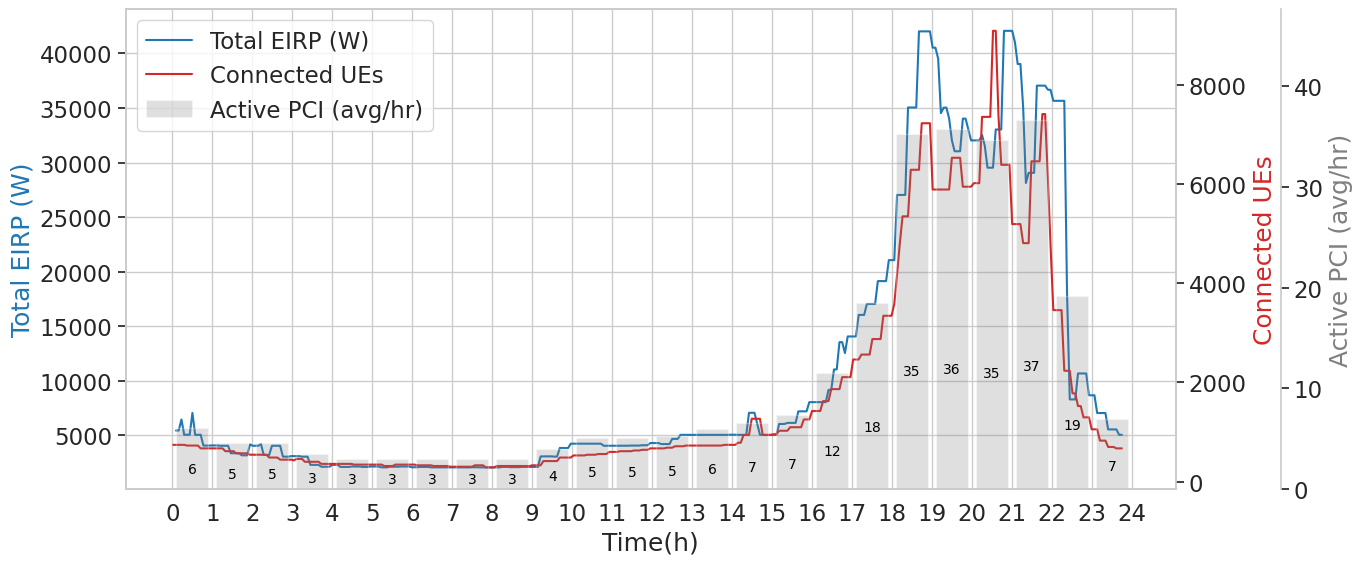

In [22]:
# Align on time
# We'll do an asof merge to interpolate UEs at power timestamps (or vice versa)
# Create uniformly sampled time axis covering both ranges
min_t = min(power_df['time_h'].min(), ues_df['time_h'].min())
max_t = max(power_df['time_h'].max(), ues_df['time_h'].max())

# Resolution: choose the finer of the two mean spacings
power_dt = np.diff(power_df['time_h']).mean() if len(power_df) > 1 else 0.01
ues_dt = np.diff(ues_df['time_h']).mean() if len(ues_df) > 1 else 0.01
step = max(min(power_dt, ues_dt), 0.001)

grid = pd.DataFrame({'time_h': np.arange(min_t, max_t + step/2, step)})

# Interpolate each series onto the grid
power_grid = pd.merge_asof(grid, power_df.sort_values('time_h'), on='time_h')
ues_grid = pd.merge_asof(grid, ues_df.sort_values('time_h'), on='time_h')

merged = grid.join(power_grid[['total_eirp_w','active_pci']], how='left')
merged = merged.join(ues_grid[['connected_ues']], how='left')

# Optional: linear interpolation for smoother plots
merged['total_eirp_w'] = merged['total_eirp_w'].interpolate()
merged['connected_ues'] = merged['connected_ues'].interpolate()

# For active_pci, we typically want step-like values; forward fill then backfill to fill gaps
merged['active_pci'] = merged['active_pci'].ffill().bfill()

# Plot with seaborn/matplotlib (style like Plot3)
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
# Remove gridlines for the secondary axis
ax2.grid(False)

# Primary lines
sns.lineplot(data=merged, x='time_h', y='total_eirp_w', ax=ax1, color='tab:blue', label='Total EIRP (W)')
sns.lineplot(data=merged, x='time_h', y='connected_ues', ax=ax2, color='tab:red', label='Connected UEs')

# Add hourly bars for active PCI count on a third axis sharing x
ax3 = ax1.twinx()
# Offset ax3 spine to the right (moved a little farther)
ax3.spines.right.set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
# Choose a neutral color for bars
hour_start = np.floor(merged['time_h'].min())
hour_end = np.ceil(merged['time_h'].max())
hours = np.arange(hour_start, hour_end, 1.0)
bar_centers = hours + 0.5
bar_width = 0.8
# Compute mean active_pci per hour bin
hour_bins = pd.cut(merged['time_h'], bins=np.append(hours, hour_end), right=False, include_lowest=True)
active_per_hour = merged.groupby(hour_bins)['active_pci'].mean().reindex(pd.IntervalIndex.from_breaks(np.append(hours, hour_end), closed='left'))
bar_vals = active_per_hour.values if active_per_hour is not None else np.array([])
# Align centers for bins
centers = hours + 0.5

bars = ax3.bar(centers, bar_vals, width=bar_width, color='gray', alpha=0.25, label='Active PCI (avg/hr)')
ax3.set_ylim(0, max(5, np.nanmax(bar_vals) * 1.3))
ax3.set_ylabel('Active PCI (avg/hr)', color='gray')
# Hide grid for ax3
ax3.grid(False)

# Annotate bars with integer rounded counts centered within the bar
for x, v in zip(centers, bar_vals):
    if np.isfinite(v) and v > 0:
        ax3.text(x, v/3.0, f"{int(round(v))}", ha='center', va='center', fontsize=10, color='black')

ax1.set_xlabel('Time(h)')
# Integer ticks like Plot3
try:
    xmin, xmax = float(merged['time_h'].min()), float(merged['time_h'].max())
    ax1.set_xticks(np.arange(int(np.floor(xmin)), int(np.ceil(xmax)) + 1, 1))
except Exception:
    pass

ax1.set_ylabel('Total EIRP (W)', color='tab:blue')
ax2.set_ylabel('Connected UEs', color='tab:red')

# Combined legend (single box)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
# Remove any per-axis legends
for ax in (ax1, ax2, ax3):
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()
# Build combined lists and drop no-legend entries
handles = []
labels = []
for h, l in list(zip(handles1, labels1)) + list(zip(handles2, labels2)) + list(zip(handles3, labels3)):
    if not l or l == '_nolegend_' or l in labels:
        continue
    handles.append(h)
    labels.append(l)
ax1.legend(handles, labels, loc='upper left', frameon=True)

plt.tight_layout()
# Save like Plot3
out_dir = base / 'out'
out_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(out_dir / 'eirp_vs_ues.png', bbox_inches='tight')
plt.savefig(out_dir / 'eirp_vs_ues.pdf', dpi=300, bbox_inches='tight')


plt.show()

## Notes
- X-axis is hours from the CSVs.
- Total EIRP (W) is computed as sum over PCI columns: EIRP_i = P_tx * 10^{(G_i - L_c)/10}. Here we assumed P_tx=1 W and cable/feeder loss L_c=0 dB (adjust in code if known).
- Connected UEs is taken from the `Connected UEs` column of `input.csv`.
- The series are interpolated onto a common grid for a smooth comparison.
- Secondary y-axis shows EIRP in dBW (10 * log10(W)).

References:
- 3GPP TR 38.104 and TS 38.104 define maximum EIRP limits for NR base stations (see sections on RF output power and OTA requirements).
- ITU-R Recommendation SM.329 and FCC 47 CFR §15 define EIRP usage for compliance (general definition: EIRP = P_tx * G_ant / L_losses).
- Rappaport, T. S., Wireless Communications: Principles and Practice, 2nd Ed., Sec. 3.5 (defines EIRP and link budget components).

If you have actual per-PCI transmit power or losses, update `base_tx_power_w` and `cable_loss_db` to reflect realistic values, or provide per-PCI P_tx columns to refine total EIRP.

## Zoomed view

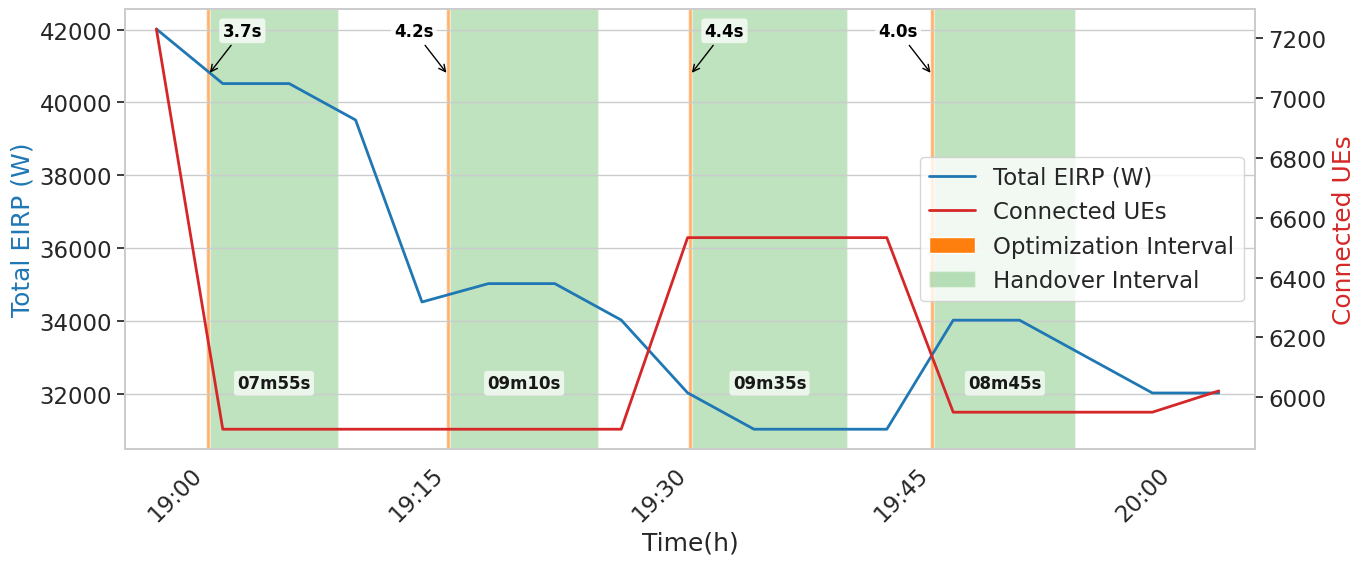

In [23]:
# Filter interval and plot
start_h, end_h = 18 + 55/60, 20 + 5/60  # 18:55 to 20:05
context_pad = 0.0  # no extra context
view_start, view_end = start_h, end_h

# Data slices
focus = merged[(merged['time_h'] >= start_h) & (merged['time_h'] <= end_h)].copy()

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
# Ensure no gridlines on ax2
ax2.grid(False)

# Emphasized focus lines (18:55–20:05)
sns.lineplot(data=focus, x='time_h', y='total_eirp_w', ax=ax1, color='tab:blue', linewidth=2, label='Total EIRP (W)')
sns.lineplot(data=focus, x='time_h', y='connected_ues', ax=ax2, color='tab:red', linewidth=2, label='Connected UEs')

ax1.set_xlabel('Time(h)')
ax1.set_xlim(view_start, view_end)
# Remove vertical gridlines on primary axis only
ax1.grid(False, axis='x')

# Optimization bars only in 19:00–20:00
opt_window_start, opt_window_end = 19.0, 20.0

# Add optimization intervals (orange) and following handover intervals (green) using provided durations
handover_label_positions = []  # (center_time, duration_seconds)
optimization_label_positions = []  # (center_time, duration_seconds)
try:
    # Editable lists (seconds)
    opt_durations_sec = [3.7, 4.2, 4.4, 4.0]
    handover_durations_sec = [475, 550, 575, 525]
    # Minimum visual width for orange intervals (in hours). 15 seconds by default.
    min_opt_width_hours = 15 / 3600
    anchors = np.linspace(opt_window_start, opt_window_end, 4, endpoint=False)
    for i, t_anchor in enumerate(anchors):
        if opt_durations_sec and i < 4:  # safeguard
            opt_dur_sec = float(opt_durations_sec[i % len(opt_durations_sec)])
            desired_width_hours = max(opt_dur_sec / 3600.0, min_opt_width_hours)
            half = desired_width_hours / 2.0
            t0 = t_anchor - half
            t1 = t_anchor + half
            # Constrain to window
            if t0 < opt_window_start:
                shift = opt_window_start - t0
                t0 += shift
                t1 += shift
            if t1 > opt_window_end:
                shift = t1 - opt_window_end
                t0 -= shift
                t1 -= shift
            # Final clamp
            t0 = max(t0, opt_window_start)
            t1 = min(t1, opt_window_end)
            # Ensure still positive width
            if t1 > t0:
                ax1.axvspan(t0, t1, facecolor='tab:orange', alpha=0.6, zorder=0)
                optimization_label_positions.append(((t0 + t1) / 2.0, opt_dur_sec))
                # Add matching handover interval immediately after optimization
                if handover_durations_sec:
                    ho_dur_sec = float(handover_durations_sec[i % len(handover_durations_sec)])
                    ho_dur_hours = ho_dur_sec / 3600.0
                    ho_start = t1
                    ho_end = min(ho_start + ho_dur_hours, opt_window_end)
                    if ho_end > ho_start:
                        ax1.axvspan(ho_start, ho_end, facecolor='tab:green', alpha=0.3, zorder=0)
                        center_time = (ho_start + ho_end) / 2.0
                        handover_label_positions.append((center_time, ho_dur_sec))
except Exception:
    pass

# Cap to 4 optimization labels in case of any future changes
optimization_label_positions = optimization_label_positions[:4]

# X ticks as HH:MM at 15-minute intervals starting at 19:00
tick_start = max(19.0, view_start)
ticks = np.arange(tick_start, view_end + 1e-9, 0.25)
ax1.set_xticks(ticks)
labels = []
for t in ticks:
    h = int(np.floor(t))
    m = int(round((t - h) * 60))
    if m == 60:
        h += 1
        m = 0
    labels.append(f"{h:02d}:{m:02d}")
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Title helper (commented out)
def _hhmm(x):
    h = int(np.floor(x))
    m = int(round((x - h) * 60))
    if m == 60:
        h += 1
        m = 0
    return f"{h:02d}:{m:02d}"
# plt.title(f"Total EIRP and Connected UEs over Time ({_hhmm(start_h)}–{_hhmm(end_h)})")

ax1.set_ylabel('Total EIRP (W)', color='tab:blue')
ax2.set_ylabel('Connected UEs', color='tab:red')

# Helper to format durations with higher precision
def format_duration(d):
    if d < 60:
        return f"{d:.1f}s"  # seconds with one decimal
    m = int(d // 60)
    s = d - 60 * m
    return f"{m:02d}m{s:.0f}s"  # minutes plus seconds (raw seconds remainder)

# After setting lines, get y-limits
ymin, ymax = ax1.get_ylim()
y_range = ymax - ymin

# Annotate optimization (orange) intervals with arrows
opt_target_y = ymin + 0.85 * y_range
opt_text_y = ymin + 0.93 * y_range
for i, (center_time, dur_s) in enumerate(optimization_label_positions):
    opt_label = format_duration(dur_s)
    dx = 0.015 * (1 if i % 2 == 0 else -1)  # alternate left/right text anchor
    text_x = center_time + dx
    text_x = max(view_start + 0.001, min(view_end - 0.001, text_x))
    ha = 'left' if dx > 0 else 'right'
    ax1.annotate(opt_label,
                 xy=(center_time, opt_target_y), xycoords='data',
                 xytext=(text_x, opt_text_y), textcoords='data',
                 arrowprops=dict(arrowstyle='->', color='black', lw=1),
                 ha=ha, va='bottom', fontsize=12, fontweight='bold', color='black',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.75))

# Annotate handover (green) intervals with inline labels near bottom
y_text = ymin + 0.15 * y_range  # 15% from bottom
for center_time, dur_s in handover_label_positions:
    label = format_duration(dur_s)
    ax1.text(center_time, y_text, label, ha='center', va='center', fontsize=12,
             color='black', fontweight='bold', alpha=0.9,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7))

# Combined legend (single box) with patches for intervals
from matplotlib.patches import Patch
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
for ax in (ax1, ax2):
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()
handles, labels = [], []
for h, l in list(zip(h1, l1)) + list(zip(h2, l2)):
    if not l or l == '_nolegend_' or l in labels:
        continue
    handles.append(h)
    labels.append(l)
opt_patch = Patch(facecolor='tab:orange', label='Optimization Interval')
ho_patch = Patch(facecolor='tab:green', alpha=0.3, label='Handover Interval')
if 'Optimization Interval' not in labels:
    handles.append(opt_patch)
    labels.append('Optimization Interval')
if 'Handover Interval' not in labels:
    handles.append(ho_patch)
    labels.append('Handover Interval')
ax1.legend(handles, labels, loc='center right', frameon=True)

plt.tight_layout()
# Ensure output directory exists and save zoomed plot
out_dir = base / 'out'
out_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_dir / f'eirp_vs_ues_zoom.png', bbox_inches='tight')
plt.savefig(out_dir / f'eirp_vs_ues_zoom.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
# Energy integration (absolute Joule estimates layered on normalized NEIRP)
import numpy as np
import pandas as pd
from dataclasses import dataclass

@dataclass
class EnergyModel:
    per_pci_tx_power_w: float = 20.0  # assumed conducted power per active PCI (W)
    feeder_loss_db: float = 0.0       # optional feeder/cable loss to subtract (dB)
    pa_efficiency: float = 0.35       # power amplifier drain efficiency (fraction)
    bbu_overhead_w: float = 50.0      # constant baseband + control overhead per site (W)
    cooling_overhead_fraction: float = 0.10  # fraction of (RF + BBU) for cooling

# Duplicate merged so we do not mutate plotting data
energy_df = merged.copy()

# Active PCIs already present: energy_df['active_pci']
model = EnergyModel()

# Effective radiated NEIRP currently assumes 1 W per PCI * gain_linear; aggregate NEIRP ~ proportional to active_pci.
# We convert to conducted RF output power approximation:
# Conducted_RF(t) = active_pci(t) * model.per_pci_tx_power_w
conducted_rf_w = energy_df['active_pci'] * model.per_pci_tx_power_w

# DC power drawn by PAs given efficiency
pa_dc_input_w = conducted_rf_w / max(model.pa_efficiency, 1e-6)

# Add constant BBU/control overhead (only if at least one PCI active)
bbu_w = np.where(energy_df['active_pci'] > 0, model.bbu_overhead_w, 0.0)

# Total before cooling
total_before_cooling_w = pa_dc_input_w + bbu_w

# Cooling / ancillary overhead
cooling_w = total_before_cooling_w * model.cooling_overhead_fraction

# Total site power
site_power_w = total_before_cooling_w + cooling_w
energy_df['site_power_w'] = site_power_w

# Time axis in hours -> convert to seconds for integration
time_h = energy_df['time_h'].values
# Ensure sorted
order = np.argsort(time_h)
energy_df = energy_df.iloc[order].reset_index(drop=True)
time_h = energy_df['time_h'].values

# Convert hours to seconds
time_s = time_h * 3600.0

# Integrate using trapezoidal rule (Joules = W * s)
energy_joules = np.trapz(energy_df['site_power_w'].values, x=time_s)

# Baseline all-on scenario (every timestamp has max active_pci observed)
max_active = energy_df['active_pci'].max()
conducted_rf_all_on_w = max_active * model.per_pci_tx_power_w
pa_dc_all_on_w = conducted_rf_all_on_w / max(model.pa_efficiency, 1e-6)
bbu_all_on_w = model.bbu_overhead_w  # always on
cooling_all_on_w = (pa_dc_all_on_w + bbu_all_on_w) * model.cooling_overhead_fraction
site_all_on_w = pa_dc_all_on_w + bbu_all_on_w + cooling_all_on_w
energy_all_on_joules = site_all_on_w * (time_s[-1] - time_s[0])

savings_fraction = 1.0 - (energy_joules / energy_all_on_joules if energy_all_on_joules > 0 else np.nan)

print(f"Integrated site energy (adaptive): {energy_joules/3600:.2f} Wh ({energy_joules:.2f} J)")
print(f"Integrated site energy (all-on):  {energy_all_on_joules/3600:.2f} Wh ({energy_all_on_joules:.2f} J)")
print(f"Relative energy savings: {savings_fraction*100:.2f}%")

# Layered breakdown (average powers)
avg_site_power = energy_df['site_power_w'].mean()
avg_pa_dc = pa_dc_input_w.mean()
avg_bbu = bbu_w.mean()
avg_cooling = cooling_w.mean()
print("Average power components (W):")
print(f"  PA DC input: {avg_pa_dc:.2f} W")
print(f"  BBU/control: {avg_bbu:.2f} W")
print(f"  Cooling:     {avg_cooling:.2f} W")
print(f"  Total site:  {avg_site_power:.2f} W")

# Store summary to CSV for reproducibility
summary_path = base / 'out' / 'energy_summary.csv'
pd.DataFrame({
    'energy_joules':[energy_joules],
    'energy_all_on_joules':[energy_all_on_joules],
    'savings_fraction':[savings_fraction],
    'avg_pa_dc_w':[avg_pa_dc],
    'avg_bbu_w':[avg_bbu],
    'avg_cooling_w':[avg_cooling],
    'avg_site_w':[avg_site_power],
    'per_pci_tx_power_w':[model.per_pci_tx_power_w],
    'pa_efficiency':[model.pa_efficiency],
    'bbu_overhead_w':[model.bbu_overhead_w],
    'cooling_fraction':[model.cooling_overhead_fraction]
}).to_csv(summary_path, index=False)
print(f"Saved summary to {summary_path}")

Integrated site energy (adaptive): 18267.88 Wh (65764381.92 J)
Integrated site energy (all-on):  65440.43 Wh (235585544.41 J)
Relative energy savings: 72.08%
Average power components (W):
  PA DC input: 648.99 W
  BBU/control: 50.00 W
  Cooling:     69.90 W
  Total site:  768.89 W
Saved summary to /home/vmadmin/Energy-Saver-Tests/results/energy-over-time/out/energy_summary.csv
